In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.6 MB/s eta 0:00:00


In [241]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [238]:
# Upload file using Colab file upload dialog
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: 

In [242]:
filename = 'AAPL_stock_data.csv'

# Load the dataset
dateparse = lambda dates: pd.to_datetime(dates, format='%m/%d/%Y')
stock_data = pd.read_csv(filename, sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data.columns = stock_data.columns.str.strip()
# Display the first few rows of the dataset
print(stock_data.head())


           Close/Last     Volume      Open      High       Low
Date                                                          
2020-02-28    $273.36  106721200   $257.26   $278.41   $256.37
2020-02-27    $273.52   80151380    $281.1      $286   $272.96
2020-02-26    $292.65   49678430   $286.53   $297.88    $286.5
2020-02-25    $288.08   57668360   $300.95   $302.53   $286.13
2020-02-24    $298.18   55548830   $297.26   $304.18   $289.23


In [243]:
stock_data['Close/Last'] = pd.to_numeric(stock_data['Close/Last'].str.replace('$', ''), errors='coerce')

In [244]:
stock_data= stock_data.sort_values(by='Date', ascending=True)

In [245]:
stock_data

,Close/Last,Volume,Open,High,Low
Date,,,,,
2010-03-01,29.8557,137312041,$29.3928,$29.9286,$29.35
2010-03-02,29.8357,141486282,$29.99,$30.1186,$29.6771
2010-03-03,29.9043,92846488,$29.8486,$29.9814,$29.7057
2010-03-04,30.1014,89591907,$29.8971,$30.1314,$29.8043
2010-03-05,31.2786,224647427,$30.7057,$31.3857,$30.6614
...,...,...,...,...,...
2020-02-24,298.1800,55548830,$297.26,$304.18,$289.23
2020-02-25,288.0800,57668360,$300.95,$302.53,$286.13
2020-02-26,292.6500,49678430,$286.53,$297.88,$286.5


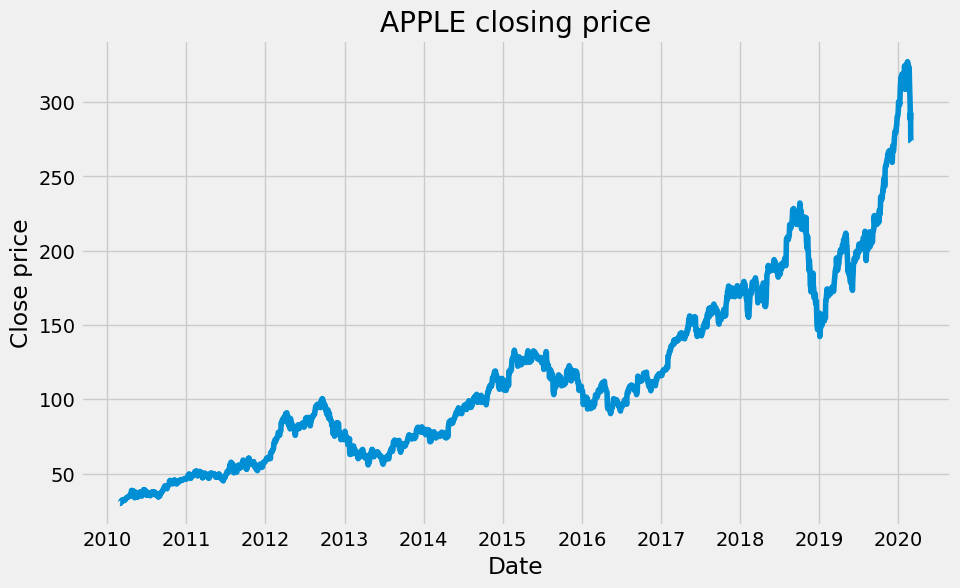

In [246]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close price')
plt.plot(stock_data['Close/Last'])
plt.title('APPLE closing price')
plt.show()

<Axes: ylabel='Density'>

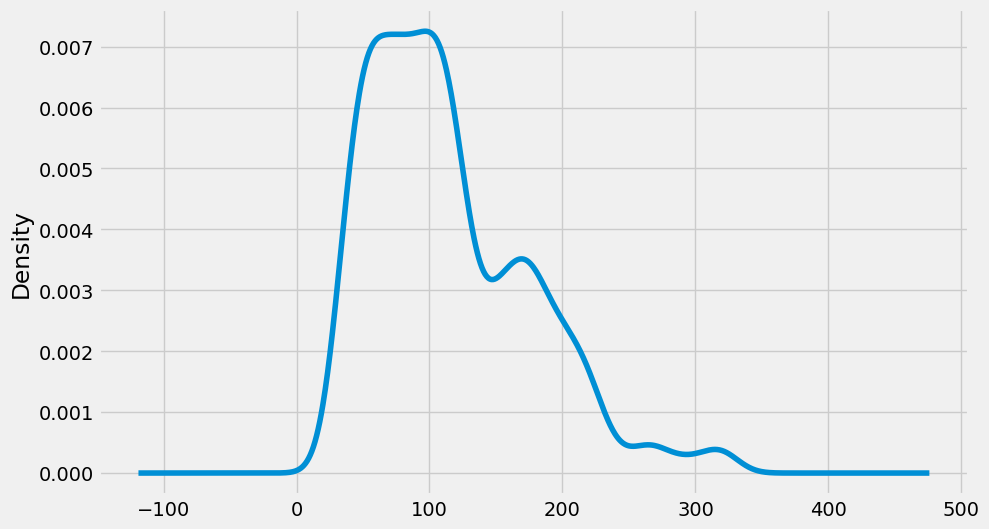

In [247]:
#Distribution of the dataset
stock_data['Close/Last'].plot(kind='kde')

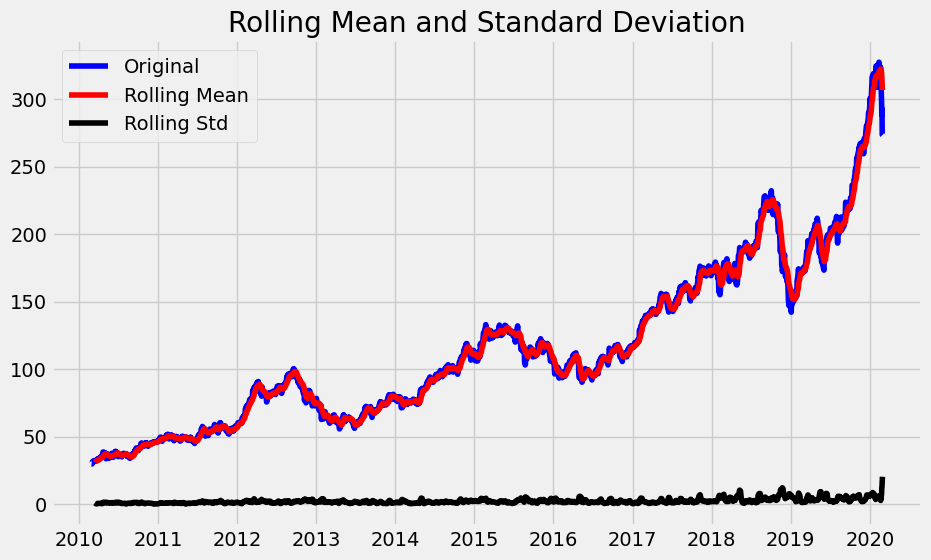

Results of dickey fuller test
Test Statistics                   0.049181
p-value                           0.962415
No. of lags used                  9.000000
Number of observations used    2508.000000
critical value (1%)              -3.432960
critical value (5%)              -2.862693
critical value (10%)             -2.567384
dtype: float64


In [248]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(stock_data['Close/Last'])

<Figure size 1000x600 with 0 Axes>

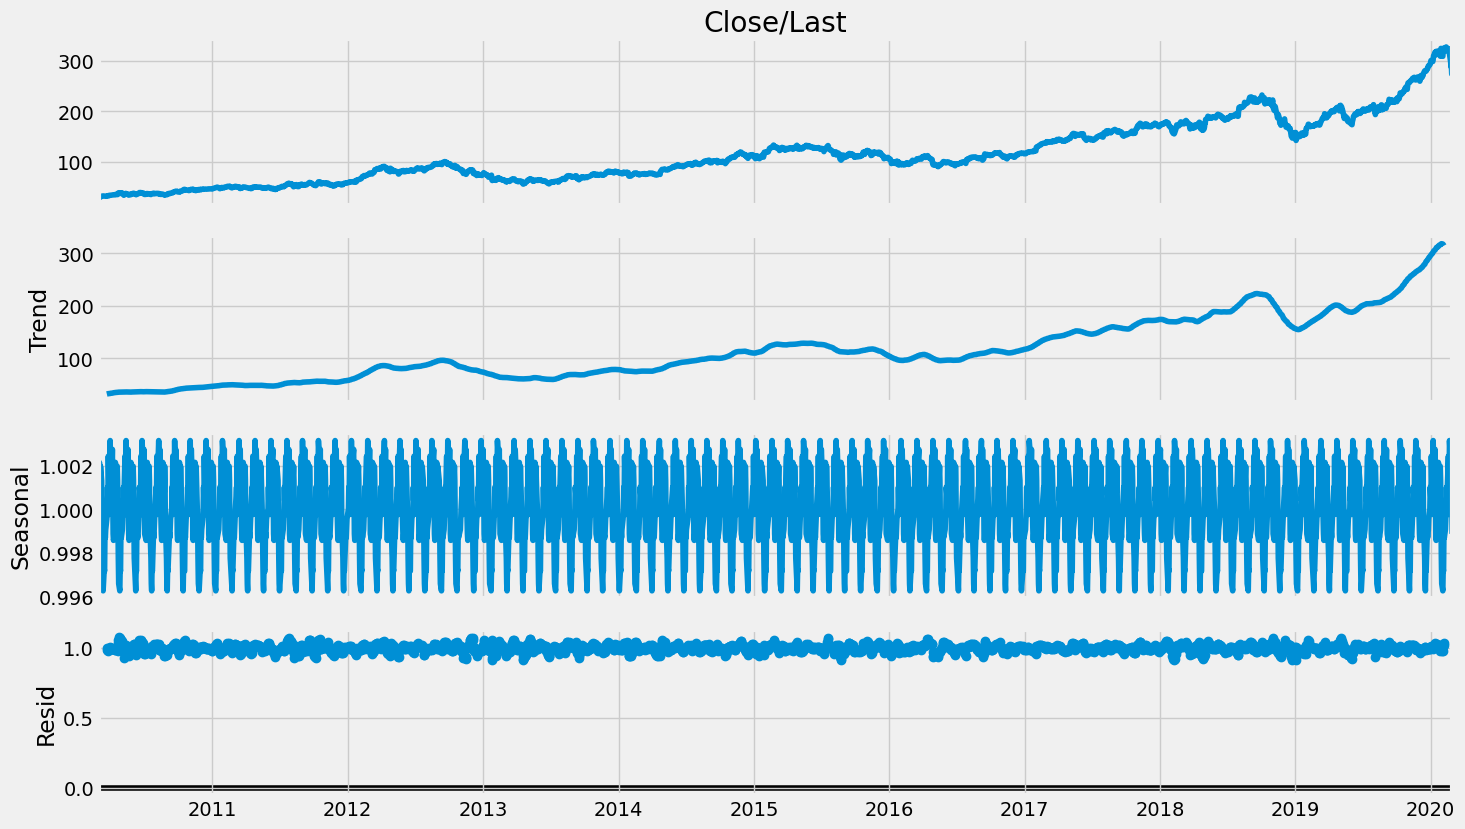

In [249]:
#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
result = seasonal_decompose(stock_data['Close/Last'], model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

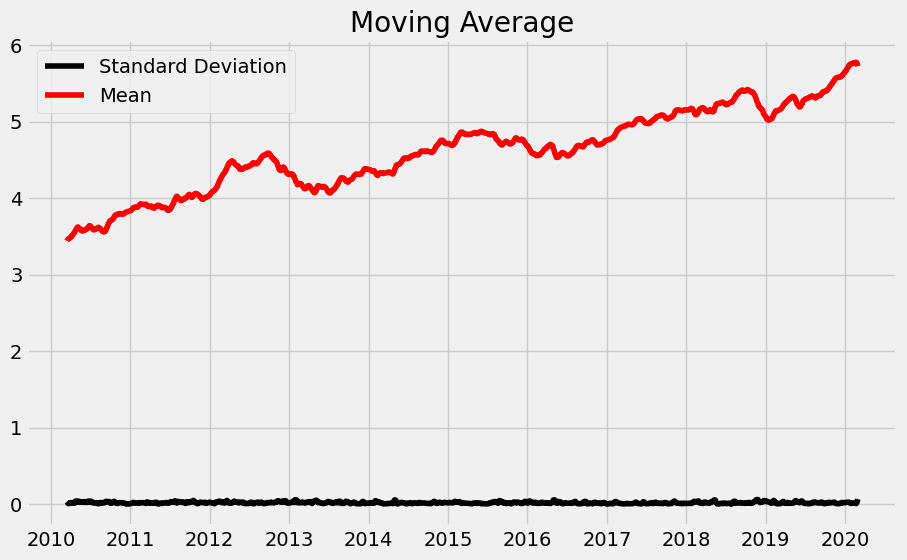

In [250]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(stock_data['Close/Last'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

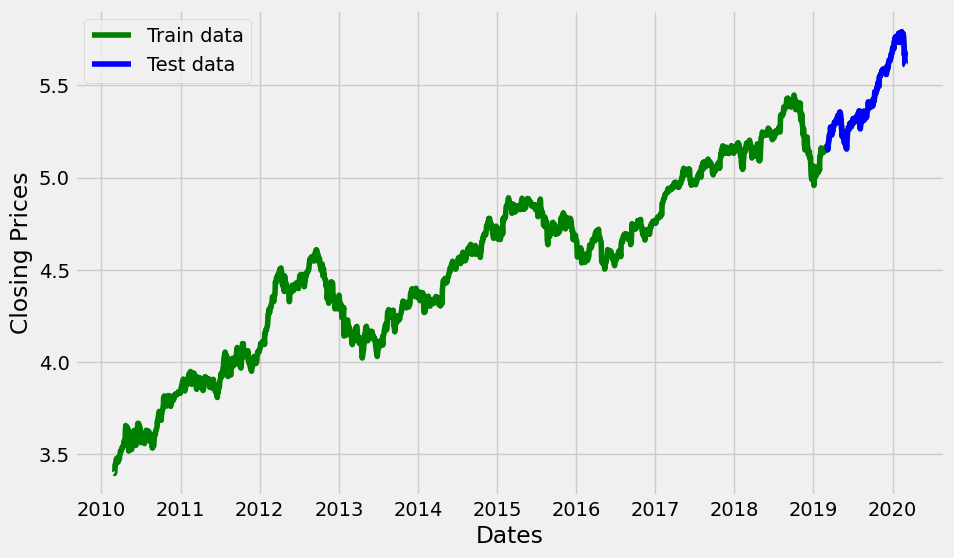

In [251]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [193]:
# print("Train data length:", len(train_data))
# print("Test data length:", len(test_data))
# print("Train data indices:", train_data.index)
# print("Test data indices:", test_data.index)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12195.370, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12194.465, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12194.482, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12192.293, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12192.512, Time=1.32 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.387 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2263
Model:               SARIMAX(0, 1, 0)   Log Likelihood                6099.685
Date:                Fri, 09 Aug 2024   AIC                         -12195.370
Time:                        18:45:52   BIC                         -12183.922
Sample:                             0   HQIC                        -12191.193
                               - 2263                             

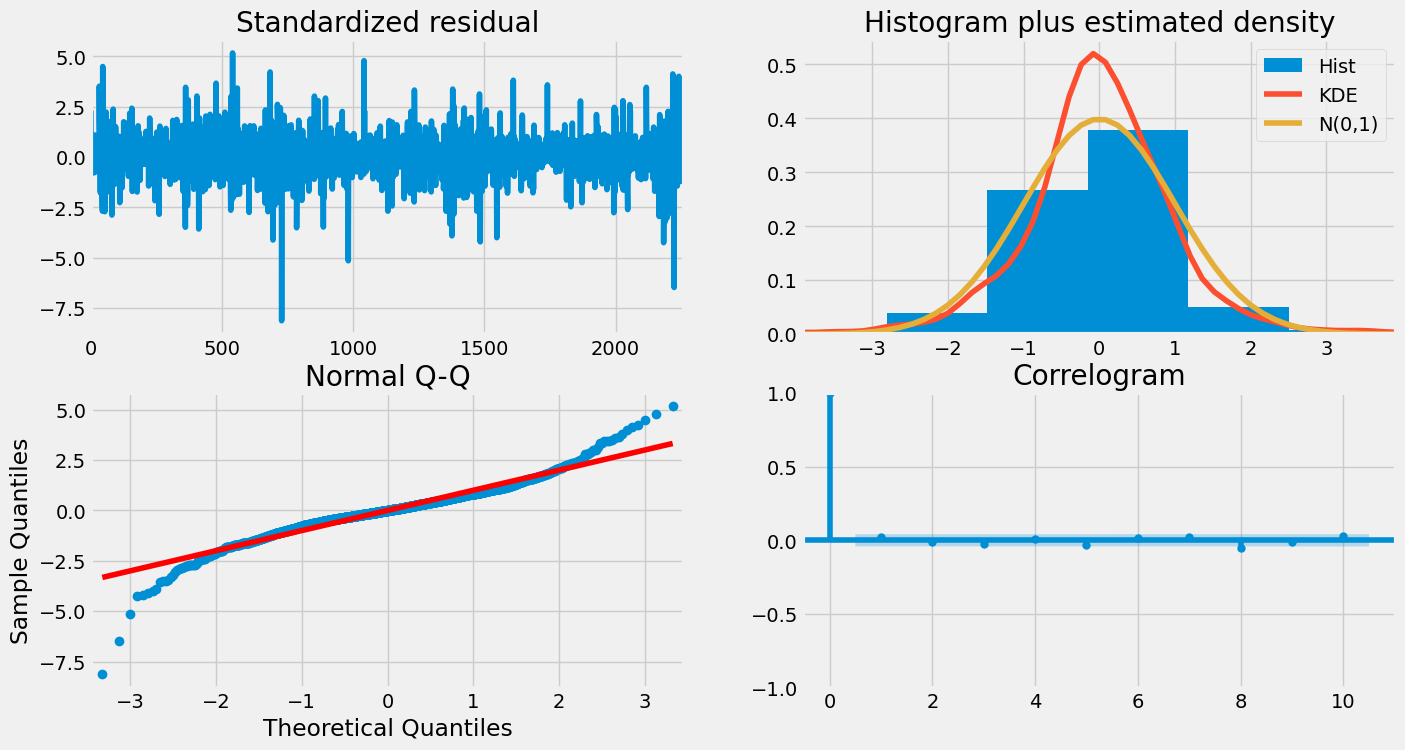

In [252]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [253]:
#Modeling
# Build Model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(0,1,0))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:             Close/Last   No. Observations:                 2263
Model:                 ARIMA(0, 1, 0)   Log Likelihood                6097.147
Date:                Fri, 09 Aug 2024   AIC                         -12192.293
Time:                        18:45:53   BIC                         -12186.569
Sample:                             0   HQIC                        -12190.205
                               - 2263                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   4.24e-06     62.952      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):              2470.47
Prob(Q):                              0.30   Pr

In [254]:
# Forecasting
forecast_steps = len(test_data)  # Number of steps to forecast
forecast = fitted.forecast(steps=forecast_steps)

# # Convert forecasts to a Pandas Series
# forecast_series = pd.Series(forecast, index=test_data.index)
# lower_series = pd.Series(conf_int[:, 0], index=test_data.index)
# upper_series = pd.Series(conf_int[:, 1], index=test_data.index)


In [255]:
print(forecast)

2263    5.154158
2264    5.154158
2265    5.154158
2266    5.154158
2267    5.154158
          ...   
2510    5.154158
2511    5.154158
2512    5.154158
2513    5.154158
2514    5.154158
Name: predicted_mean, Length: 252, dtype: float64


In [256]:
# Forecasting
# forecast, stderr, conf_int = fitted.forecast(steps=len(test_data))  # Number of steps equals the length of the test set


In [257]:
len(train_data)

2263

In [258]:
len(test_data)

252

In [259]:
len(stock_data)

2518

In [260]:
# Forecast
# fc, se, conf = fitted.forecast(321, alpha=0.05)  # 95% conf

In [261]:
# Forecast
forecast_result = fitted.get_forecast(len(test_data), alpha=0.05)  # 95% conf
# Use get_forecast() instead of forecast() to get a forecast object
fc = forecast_result.predicted_mean
se = forecast_result.se_mean
conf = forecast_result.conf_int()

print("Forecast:", fc)
print("Standard Error:", se)
print("Confidence Interval:", conf)

Forecast: 2263    5.154158
2264    5.154158
2265    5.154158
2266    5.154158
2267    5.154158
          ...   
2510    5.154158
2511    5.154158
2512    5.154158
2513    5.154158
2514    5.154158
Name: predicted_mean, Length: 252, dtype: float64
Standard Error: 2263    0.016332
2264    0.023097
2265    0.028288
2266    0.032664
2267    0.036520
          ...   
2510    0.257197
2511    0.257715
2512    0.258232
2513    0.258748
2514    0.259263
Name: var_pred_mean, Length: 252, dtype: float64
Confidence Interval:       lower Close/Last  upper Close/Last
2263          5.122148          5.186168
2264          5.108889          5.199428
2265          5.098715          5.209602
2266          5.090138          5.218179
2267          5.082581          5.225735
...                ...               ...
2510          4.650061          5.658255
2511          4.649046          5.659271
2512          4.648033          5.660284
2513          4.647021          5.661295
2514          4.646012       

In [262]:
# Make as pandas series
fc_series = pd.Series(len(test_data), index=test_data.index)
print(len(conf.iloc[:, 0].values), len(test_data.index))

lower_series = pd.Series(conf.iloc[:len(test_data), 0].values, index=test_data.index)
upper_series = pd.Series(conf.iloc[:len(test_data), 1].values, index=test_data.index)
# lower_series = pd.Series(conf.iloc[:, 0].values, index=test_data.index) # Extract values from DataFrame column
# upper_series = pd.Series(conf.iloc[:, 1].values, index=test_data.index) # Extract values from DataFrame column

252 252


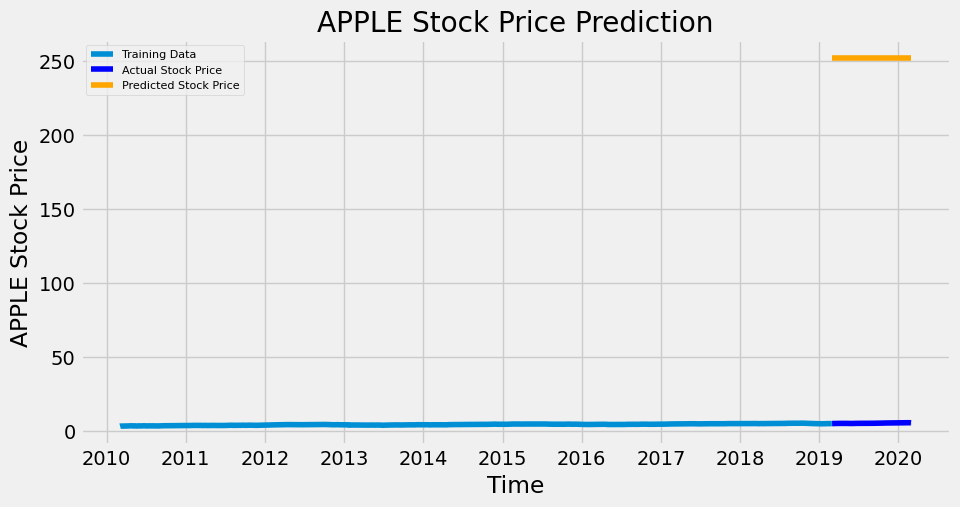

In [263]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.1)
plt.title('APPLE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [264]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.10937403831410492
MAE: 0.27481776731182256
RMSE: 0.3307174599474677
MAPE: nan
